Title: Feedback-based quantum algorithm inspired by conterdiabatic driving

Authors: Rajesh K. Malla, Hiroki Sukeno, Hongye Yu, Tzu-Chieh Wei, Andreas Weichselbaum, Robert M. Konik

This code is developed based on a tutorial [David Wakeham and Jack Ceroni (2021)].

Reference:

David Wakeham and Jack Ceroni, "Feedback-Based Quantum Optimization (FALQON)," PennyLane Demos, Xanadu (2021), url: https://pennylane.ai/qml/demos/tutorial_falqon/

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

In [ ]:
def edge_periodic_chain(n):
    edge = [ (k+1,k+2) for k in range(n-1)]
    edge.append( (n,1) )
    return edge

def graph_pchain(n):
    return nx.Graph( edge_periodic_chain(n) )

def TLFI_hamiltonian(n,J,hx,hz):
    H = qml.Hamiltonian([], [])

    for site in graph_pchain(n).nodes:
        k = site
        H += - hx* (qml.PauliX(k))
        H += - hz* (qml.PauliZ(k))

    for edge in graph_pchain(n).edges:
        i, j = edge
        H += -J* ( qml.PauliZ(i) @ qml.PauliZ(j))

    return H


print("TLFI Hamiltonian")
print(TLFI_hamiltonian(6,1.0,0.4,0.4))

def drift_H(n):
    H = qml.Hamiltonian([], [])

    for site in graph_pchain(n).nodes:
        k = site
        H += (qml.PauliX(k))
    return H


def commutator_TLFI(n,J,hx,hz):
    H = qml.Hamiltonian([], [])

    for site in graph_pchain(n).nodes:
        k = site
        H += - 2*hz* (qml.PauliY(k))

    for edge in graph_pchain(n).edges:
        i, j = edge
        H += -2*J* ( qml.PauliZ(i) @ qml.PauliY(j)) -2*J* ( qml.PauliY(i) @ qml.PauliZ(j))

    return H


def TLFI_cd_pool(n,typeofpool):

    if typeofpool == "None":
        H = qml.Hamiltonian([], [])
        H += 0
        return H

    elif typeofpool == "Y":
        H = qml.Hamiltonian([], [])
        for site in graph_pchain(n).nodes:
            k = site
            H += qml.PauliY(k)
        return H

    elif typeofpool == "YZ":
        H = qml.Hamiltonian([], [])
        for edge in [ (k+1,k+2) for k in range(n-1)]:
            i, j = edge
            H += qml.PauliZ(i) @ qml.PauliY(j)
        H += qml.PauliZ(n) @ qml.PauliY(1)
        return H

    elif typeofpool == "YX":
        H = qml.Hamiltonian([], [])
        for edge in [ (k+1,k+2) for k in range(n-1)]:
            i, j = edge
            H += qml.PauliY(i) @ qml.PauliX(j)
        H += qml.PauliY(n) @ qml.PauliX(1)
        return H

    else:
        print("type of pool is not valid")


def cd_commutator_TLFI(n,J,hx,hz,typeofpool):

    if typeofpool == "None":
        ham = qml.Hamiltonian([],[])
        ham += 0
        return ham

    elif typeofpool == "Y":
        ham = qml.Hamiltonian([],[])
        for k in [k+1 for k in range(n)]:
            if 1<k<n:
                ham += 2*J*qml.PauliZ(k-1)@qml.PauliX(k)
                ham += 2*J*qml.PauliX(k)@qml.PauliZ(k+1)
                ham += 2*hz*qml.PauliX(k)
                ham += -2*hx*qml.PauliZ(k)
            elif k ==1:
                #ham = qml.Hamiltonian([],[])
                ham += 2*J*qml.PauliZ(n)@qml.PauliX(1)
                ham += 2*J*qml.PauliX(1)@qml.PauliZ(2)
                ham += 2*hz*qml.PauliX(1)
                ham += -2*hx*qml.PauliZ(1)
            elif k ==n:
                #ham = qml.Hamiltonian([],[])
                ham += 2*J*qml.PauliZ(n-1)@qml.PauliX(n)
                ham += 2*J*qml.PauliX(n)@qml.PauliZ(1)
                ham += 2*hz*qml.PauliX(n)
                ham += -2*hx*qml.PauliZ(n)
        return ham

    elif  typeofpool == "YZ":
        ham = qml.Hamiltonian([],[])
        for k in [k+1 for k in range(n)]:
            if k<n-1:
                ham += 2*J*qml.PauliX(k+1)
                ham += 2*J*qml.PauliZ(k)@qml.PauliX(k+1)@qml.PauliZ(k+2)
                ham += 2*hx*qml.PauliY(k)@qml.PauliY(k+1)
                ham += -2*hx*qml.PauliZ(k)@qml.PauliZ(k+1)
                ham += 2*hz*qml.PauliZ(k)@qml.PauliX(k+1)
            elif k==n-1:
                ham += 2*J*qml.PauliX(k+1)
                ham += 2*J*qml.PauliZ(k)@qml.PauliX(k+1)@qml.PauliZ(1)
                ham += 2*hx*qml.PauliY(k)@qml.PauliY(k+1)
                ham += -2*hx*qml.PauliZ(k)@qml.PauliZ(k+1)
                ham += 2*hz*qml.PauliZ(k)@qml.PauliX(k+1)
            elif k==n:
                ham += 2*J*qml.PauliX(1)
                ham += 2*J*qml.PauliZ(k)@qml.PauliX(1)@qml.PauliZ(2)
                ham += 2*hx*qml.PauliY(k)@qml.PauliY(1)
                ham += -2*hx*qml.PauliZ(k)@qml.PauliZ(1)
                ham += 2*hz*qml.PauliZ(k)@qml.PauliX(1)
        return ham

    elif  typeofpool == "YX":
        ham = qml.Hamiltonian([],[])
        for k in [k+1 for k in range(n)]:
            if k<n-1:
                ham += -2*J*qml.PauliY(k)@qml.PauliY(k+1)@qml.PauliZ(k+2)
                ham += +2*J*qml.PauliZ(k)@qml.PauliX(k+1)@qml.PauliX(k+2)
                ham += -2*hx*qml.PauliZ(k)@qml.PauliX(k+1)
                ham += 2*hz*qml.PauliX(k)@qml.PauliX(k+1)
                ham += -2*hz*qml.PauliY(k)@qml.PauliY(k+1)
            elif k==n-1:
                ham += -2*J*qml.PauliY(k)@qml.PauliY(k+1)@qml.PauliZ(1)
                ham += 2*J*qml.PauliZ(k)@qml.PauliX(k+1)@qml.PauliX(1)
                ham += -2*hx*qml.PauliZ(k)@qml.PauliX(k+1)
                ham += 2*hz*qml.PauliX(k)@qml.PauliX(k+1)
                ham += -2*hz*qml.PauliY(k)@qml.PauliY(k+1)
            elif k==n:
                ham += -2*J*qml.PauliY(k)@qml.PauliY(1)@qml.PauliZ(2)
                ham += 2*J*qml.PauliZ(k)@qml.PauliX(1)@qml.PauliX(2)
                ham += -2*hx*qml.PauliZ(k)@qml.PauliX(1)
                ham += 2*hz*qml.PauliX(k)@qml.PauliX(1)
                ham += -2*hz*qml.PauliY(k)@qml.PauliY(1)
        return ham

TLFI Hamiltonian
  (-0.4) [X1]
+ (-0.4) [Z1]
+ (-0.4) [X2]
+ (-0.4) [Z2]
+ (-0.4) [X3]
+ (-0.4) [Z3]
+ (-0.4) [X4]
+ (-0.4) [Z4]
+ (-0.4) [X5]
+ (-0.4) [Z5]
+ (-0.4) [X6]
+ (-0.4) [Z6]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z1 Z6]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z4]
+ (-1.0) [Z4 Z5]
+ (-1.0) [Z5 Z6]


The counterdiabatic commutator for the $YX$ operator:
$$
i[YX,H_p] = 2J YYZ  - 2J ZXX + 2 h_x ZX - 2h_z XX + 2h_z YY ,
$$
where $(ZX)$ stands for the sum of the local product $\sigma^Z_j \sigma^X_j$.

FALQON

In [ ]:
def falqon_layer(beta_k, prob_h, drift_h, delta_t):
    qml.ApproxTimeEvolution(prob_h, delta_t, 1)
    qml.ApproxTimeEvolution(drift_h, delta_t * beta_k, 1)

def falqon_build_ansatz(prob_h, drift_h, delta_t):
    def ansatz(beta,**kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)

        for k in range(layers):
            falqon_layer(beta[k], prob_h, drift_h, delta_t)

    return ansatz


def falqon_expval_circuit(beta,measurement_h):
    ansatz = falqon_build_ansatz(prob_h, drift_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

In [ ]:
n = 6
depth = 20
beta_1 = 0.0
delta_t = 0.02
J=1.0
hz = 0.4
hx = 0.4

comm_h = commutator_TLFI(n,J,hx,hz)
prob_h = TLFI_hamiltonian(n,J,hx,hz)
drift_h = drift_H(n)
dev = qml.device("default.qubit", wires=graph_pchain(n).nodes) # Creates a device for the simulation
cost_fn = qml.QNode(falqon_expval_circuit, dev, interface="autograd")

beta = [beta_1] # Records each value of beta_k
energies = [] # Records the value of the cost function at each step

for i in range(depth):
    # Adds a value of beta to the list and evaluates the cost function
    beta.append(-1 * cost_fn(beta, measurement_h=comm_h ))  # this call measures the expectation of the commuter hamiltonian
    energy = cost_fn(beta, measurement_h=prob_h)  # this call measures the expectation of the cost hamiltonian
    energies.append(energy)
    print(energy)

-2.4344057131613037
-2.5549373366419577
-2.7799711149806074
-3.090981340374947
-3.4206397647035174
-3.69525363788842
-3.888001265217824
-4.015569938296748
-4.104002648722662
-4.171745038072252
-4.229198012778657
-4.281897908533188
-4.33283875318011
-4.383726936366439
-4.435609776979031
-4.489184259619505
-4.544946368767261
-4.60326074877853
-4.664390360627511
-4.728506316383381


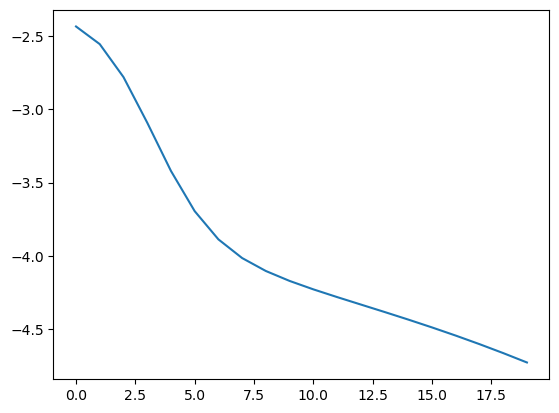

In [ ]:
plt.plot(range(depth),energies)

In [ ]:
def cd_falqon_layer(beta_k, gammas_k, prob_h, drift_h, pool_h, delta_t):
    qml.ApproxTimeEvolution(prob_h, delta_t, 1)
    qml.ApproxTimeEvolution(drift_h, delta_t * beta_k, 1)
    if typeofpool != "None":
        qml.ApproxTimeEvolution(pool_h, delta_t*gammas_k,1)  ###


def cd_falqon_build_ansatz(prob_h, drift_h, pool_h, delta_t):
    def ansatz(beta, gamma,**kwargs):
        layers = len(beta)

        for w in dev.wires:
            qml.Hadamard(wires=w)

        for k in range(layers):
            cd_falqon_layer(beta[k], gamma[k], prob_h, drift_h, pool_h, delta_t)

    return ansatz


def cd_falqon_expval_circuit(beta,gamma,measurement_h):
    ansatz = cd_falqon_build_ansatz(prob_h, drift_h, pool_h, delta_t)
    ansatz(beta,gamma)
    return qml.expval(measurement_h)

In [ ]:
n = 7
depth = 200
delta_t = 0.01
J=1.0
hz = 0.4
hx = 0.0
typeofpool = "Y"


beta_1 = 0.0
gamma_1 = 0.0

comm_h = commutator_TLFI(n,J,hx,hz)
comm_h_cd = cd_commutator_TLFI(n,J,hx,hz,typeofpool)

prob_h = TLFI_hamiltonian(n,J,hx,hz)
drift_h = drift_H(n)
pool_h = TLFI_cd_pool(n,typeofpool)
dev = qml.device("default.qubit", wires=graph_pchain(n).nodes) # Creates a device for the simulation

cost_fn = qml.QNode(cd_falqon_expval_circuit, dev, interface="autograd")

beta = [beta_1]
gamma = [gamma_1]
energies = []

for i in range(depth):
    # Adds a value of beta to the list and evaluates the cost function
    beta_new = -1 * cost_fn(beta,gamma, measurement_h=comm_h )  # this call measures the expectation of the commuter hamiltonian
    gamma_new_row = -1 * cost_fn(beta, gamma, measurement_h= comm_h_cd)
    energy = cost_fn(beta,gamma, measurement_h=prob_h)  # this call measures the expectation of the cost hamiltonian
    beta.append(beta_new)
    gamma.append(gamma_new_row )
    energies.append(energy)
    print(i)

file_name_beta = f'beta_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'
file_name_gamma = f'gamma_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'
file_name_energy = f'energy_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'


with open(file_name_beta, 'w') as file:
    for value in beta:
        file.write(f'{value}\n')

with open(file_name_gamma, 'w') as file:
    for value in gamma:
        file.write(f'{value}\n')

with open(file_name_energy, 'w') as file:
    for value in energies:
        file.write(f'{value}\n')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


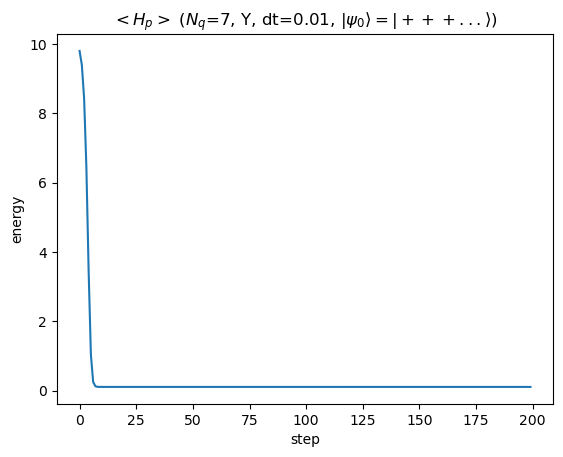

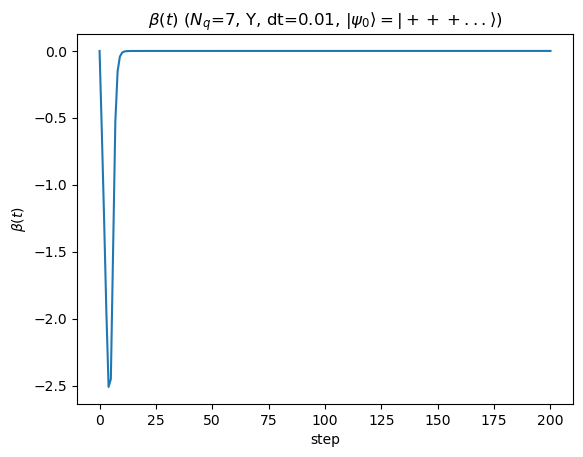

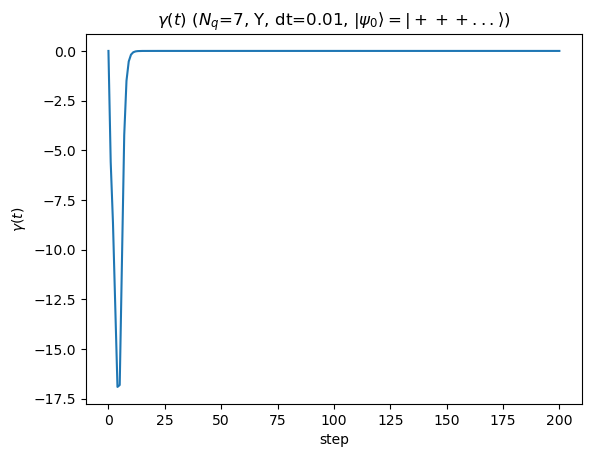

In [ ]:
import matplotlib.pyplot as plt

E0 = - 9.8
energies = [x-E0 for x in energies]

k_values = range(len(energies))
plt.plot(k_values, energies)
plt.xlabel('step')
plt.ylabel('energy')
plt.title(rf'$<H_p>$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_energy = f'energy_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_energy)
plt.show()


steps = range(len(beta))
plt.plot(steps, beta)
plt.xlabel('step')
plt.ylabel(r'$\beta(t)$')
plt.title(rf'$\beta (t)$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_beta = f'beta_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_beta)
plt.show()


steps = range(len(gamma))
plt.plot(steps, gamma)
plt.xlabel('step')
plt.ylabel(r'$\gamma(t)$')
plt.title(rf'$\gamma(t)$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_gamma = f'gamma_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_gamma)
plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


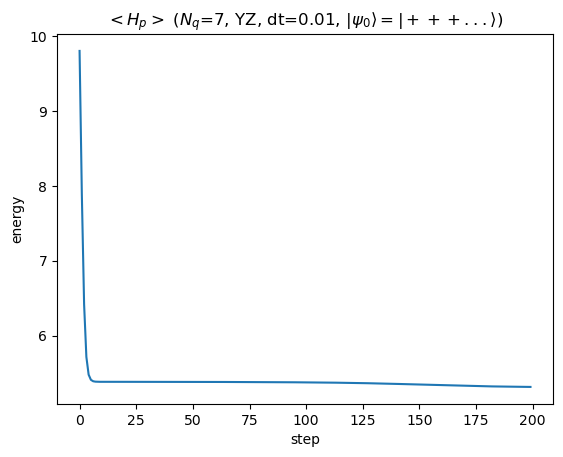

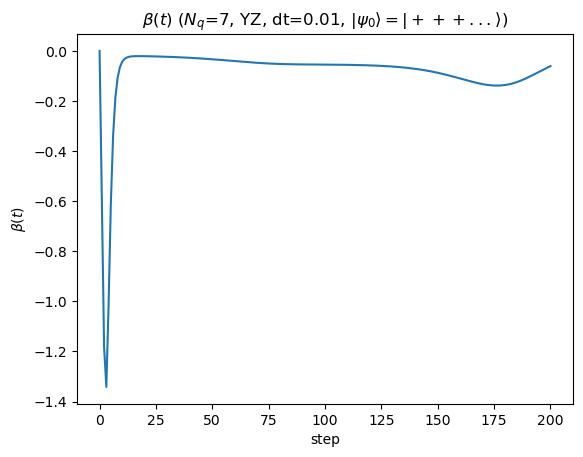

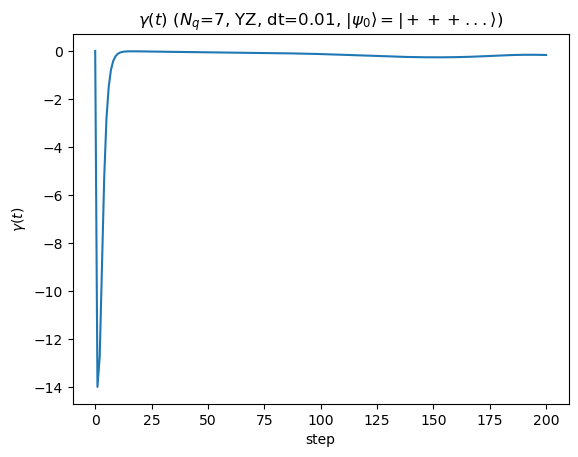

In [ ]:
n = 7
depth = 200
delta_t = 0.01
J=1.0
hz = 0.4
hx = 0.0
typeofpool = "YZ"


beta_1 = 0.0
gamma_1 = 0.0

comm_h = commutator_TLFI(n,J,hx,hz)
comm_h_cd = cd_commutator_TLFI(n,J,hx,hz,typeofpool)

prob_h = TLFI_hamiltonian(n,J,hx,hz)
drift_h = drift_H(n)
pool_h = TLFI_cd_pool(n,typeofpool)
dev = qml.device("default.qubit", wires=graph_pchain(n).nodes) # Creates a device for the simulation

cost_fn = qml.QNode(cd_falqon_expval_circuit, dev, interface="autograd")

beta = [beta_1]
gamma = [gamma_1]
energies = []

for i in range(depth):
    # Adds a value of beta to the list and evaluates the cost function
    beta_new = -1 * cost_fn(beta,gamma, measurement_h=comm_h )  # this call measures the expectation of the commuter hamiltonian
    gamma_new_row = -1 * cost_fn(beta, gamma, measurement_h= comm_h_cd)
    energy = cost_fn(beta,gamma, measurement_h=prob_h)  # this call measures the expectation of the cost hamiltonian
    beta.append(beta_new)
    gamma.append(gamma_new_row )
    energies.append(energy)
    print(i)

file_name_beta = f'beta_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'
file_name_gamma = f'gamma_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'
file_name_energy = f'energy_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'


with open(file_name_beta, 'w') as file:
    for value in beta:
        file.write(f'{value}\n')

with open(file_name_gamma, 'w') as file:
    for value in gamma:
        file.write(f'{value}\n')

with open(file_name_energy, 'w') as file:
    for value in energies:
        file.write(f'{value}\n')

import matplotlib.pyplot as plt

E0 = - 9.8
energies = [x-E0 for x in energies]

k_values = range(len(energies))
plt.plot(k_values, energies)
plt.xlabel('step')
plt.ylabel('energy')
plt.title(rf'$<H_p>$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_energy = f'energy_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_energy)
plt.show()


steps = range(len(beta))
plt.plot(steps, beta)
plt.xlabel('step')
plt.ylabel(r'$\beta(t)$')
plt.title(rf'$\beta (t)$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_beta = f'beta_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_beta)
plt.show()


steps = range(len(gamma))
plt.plot(steps, gamma)
plt.xlabel('step')
plt.ylabel(r'$\gamma(t)$')
plt.title(rf'$\gamma(t)$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_gamma = f'gamma_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_gamma)
plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


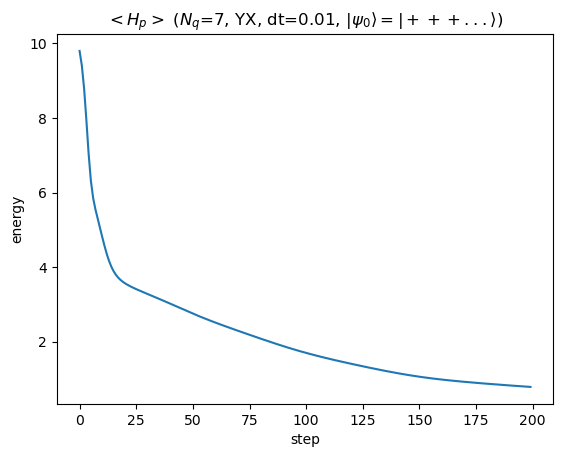

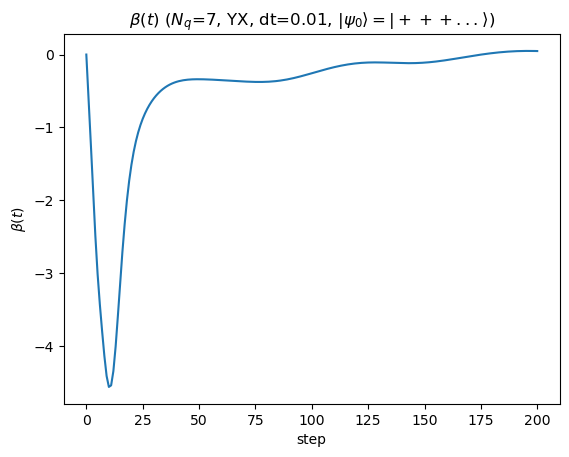

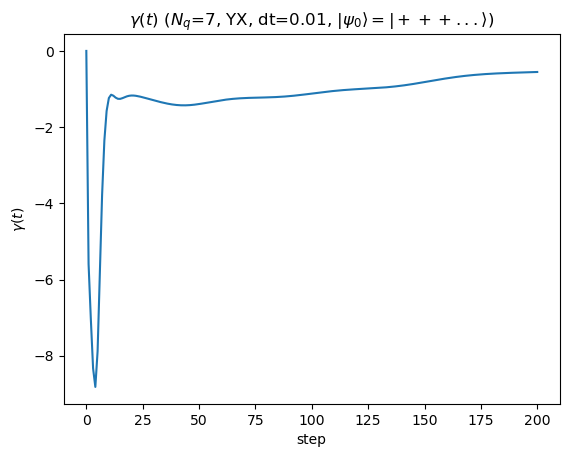

In [ ]:
n = 7
depth = 200
delta_t = 0.01
J=1.0
hz = 0.4
hx = 0.0
typeofpool = "YX"


beta_1 = 0.0
gamma_1 = 0.0

comm_h = commutator_TLFI(n,J,hx,hz)
comm_h_cd = cd_commutator_TLFI(n,J,hx,hz,typeofpool)

prob_h = TLFI_hamiltonian(n,J,hx,hz)
drift_h = drift_H(n)
pool_h = TLFI_cd_pool(n,typeofpool)
dev = qml.device("default.qubit", wires=graph_pchain(n).nodes) # Creates a device for the simulation

cost_fn = qml.QNode(cd_falqon_expval_circuit, dev, interface="autograd")

beta = [beta_1]
gamma = [gamma_1]
energies = []

for i in range(depth):
    # Adds a value of beta to the list and evaluates the cost function
    beta_new = -1 * cost_fn(beta,gamma, measurement_h=comm_h )  # this call measures the expectation of the commuter hamiltonian
    gamma_new_row = -1 * cost_fn(beta, gamma, measurement_h= comm_h_cd)
    energy = cost_fn(beta,gamma, measurement_h=prob_h)  # this call measures the expectation of the cost hamiltonian
    beta.append(beta_new)
    gamma.append(gamma_new_row )
    energies.append(energy)
    print(i)

file_name_beta = f'beta_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'
file_name_gamma = f'gamma_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'
file_name_energy = f'energy_data_n{n}_depth{depth}_dt{delta_t}_J{J}_hz{hz}_hx{hx}_{typeofpool}pool_+.txt'


with open(file_name_beta, 'w') as file:
    for value in beta:
        file.write(f'{value}\n')

with open(file_name_gamma, 'w') as file:
    for value in gamma:
        file.write(f'{value}\n')

with open(file_name_energy, 'w') as file:
    for value in energies:
        file.write(f'{value}\n')

import matplotlib.pyplot as plt

E0 = - 9.8
energies = [x-E0 for x in energies]

k_values = range(len(energies))
plt.plot(k_values, energies)
plt.xlabel('step')
plt.ylabel('energy')
plt.title(rf'$<H_p>$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_energy = f'energy_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_energy)
plt.show()


steps = range(len(beta))
plt.plot(steps, beta)
plt.xlabel('step')
plt.ylabel(r'$\beta(t)$')
plt.title(rf'$\beta (t)$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_beta = f'beta_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_beta)
plt.show()


steps = range(len(gamma))
plt.plot(steps, gamma)
plt.xlabel('step')
plt.ylabel(r'$\gamma(t)$')
plt.title(rf'$\gamma(t)$ ($N_q$={n}, {typeofpool}, dt={delta_t}, $|\psi_0\rangle=|+++...\rangle$)')
file_name_gamma = f'gamma_plot_n{n}_J{J}_hz{hz}_hx{hx}_+_{typeofpool}pool.pdf'
plt.savefig(file_name_gamma)
plt.show()
